# Process PV catalogues

In [1]:
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from h5py import File
from astropy.coordinates import match_coordinates_sky, SkyCoord
from astropy import units as u

%matplotlib inline
%load_ext autoreload
%autoreload 2

SPEED_OF_LIGHT = 299_792.458

## Supernovae data

### LOSS

In [2]:
a2dir = "/mnt/extraspace/rstiskalek/catalogs/PV/PV_Supranta/A2"

names = ["z_CMB", "mB", "x1", "c", "e_mB", "e_x1", "e_c", "RA", "DEC"]
dtype = [(n, np.float32) for n in names]
data = np.genfromtxt(join(a2dir, "loss.csv"), delimiter=",", skip_header=1,
                     usecols=[5 + n for n in range(len(names))])

loss_data = np.empty(len(data), dtype=dtype)
for i, n in enumerate(names):
    loss_data[n] = data[:, i]


### Foundation

In [3]:
names = ["z_CMB", "RA", "DEC", "x1", "mB", "c", "peak", "e_peak", "e_x1", "e_mB", "e_c"]
dtype = [(n, np.float32) for n in names]
data = np.genfromtxt(join(a2dir, "foundation.csv"), delimiter=",", skip_header=1,
                     usecols=[3 + n for n in range(len(names))])

foundation_data = np.empty(len(data), dtype=dtype)
for i, n in enumerate(names):
    foundation_data[n] = data[:, i]

### Pantheon+, all

In [138]:
fpath_full = "/mnt/extraspace/rstiskalek/catalogs/PV/Pantheon+SH0ES.dat"
fpath_group = "/mnt/extraspace/rstiskalek/catalogs/PV/pantheon+_groups.hdf5"

data_full = np.genfromtxt(fpath_full, names=True, dtype=None, encoding=None)
data_group = {}

with File(fpath_group, "r") as f:
    for key in f.keys():
        data_group[key] = f[key][:]

# data = data[data["zCMB"] < 0.1]

keys = ["zCMB", "mB", "mBERR", "x1", "x1ERR", "c", "cERR", "RA", "DEC",
        "VPEC", "VPECERR", "biasCor_m_b", "biasCorErr_m_b"]
pantheon_data = {}
for key in keys:
    pantheon_data[key] = data[key]


In [139]:
match_coord = SkyCoord(data_full["RA"], data_full["DEC"], unit="deg")
catalogue_coord = SkyCoord(data_group["RAJ2000"], data_group["DEJ2000"],
                           unit="deg")

idxs, sep2d, sep3d = match_coordinates_sky(match_coord, catalogue_coord, nthneighbor=1)
print(f"Maximum 2D separation is: {sep2d.max()}")

Maximum 2D separation is: 0.0005450609539575544 deg


In [142]:
zcmb_supernovae = data_group["zcmb"][idxs]
zcmb_group = data_group["zGcmb"][idxs]

pantheon_data["zCMB_SN"] = zcmb_supernovae
pantheon_data["zCMB_Group"] = zcmb_group

mask = pantheon_data["zCMB"] < 0.1
for key in pantheon_data.keys():
    pantheon_data[key] = pantheon_data[key][mask]

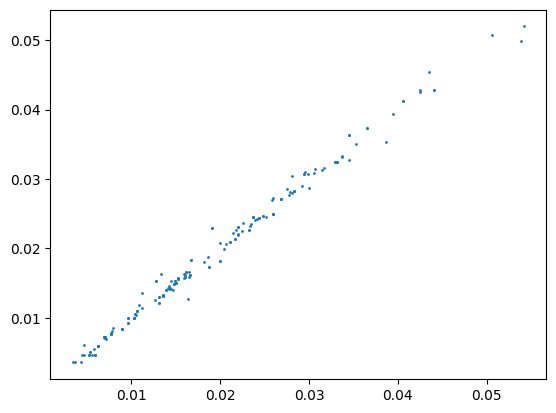

In [145]:
plt.figure()
plt.scatter(pantheon_data["zCMB_SN"], pantheon_data["zCMB_Group"], s=1)
plt.show()

## Tully-Fisher galaxies

### SFI++ galaxies

In [4]:
tf_folder = "/mnt/extraspace/rstiskalek/catalogs/PV/PV_Supranta/tf"

names = ["RA", "DEC", "z_CMB", "mag", "eta", "e_mag", "e_eta"]

dtype = [(n, np.float32) for n in names]
data = np.genfromtxt(join(tf_folder, "sfi_gals_tf.csv"), delimiter=",", skip_header=1,
                     usecols=[2 + n for n in range(len(names))])

sfi_gals = np.empty(len(data), dtype=dtype)
for i, n in enumerate(names):
    sfi_gals[n] = data[:, i]


### SFI++ galaxies masked

In [5]:
names = ["RA", "DEC", "z_CMB", "mag", "eta", "e_mag", "e_eta"]

dtype = [(n, np.float32) for n in names]
data = np.genfromtxt(join(tf_folder, "sfi_gals_tf_masked.csv"), delimiter=",", skip_header=1,
                     usecols=[2 + n for n in range(len(names))])

sfi_gals_masked = np.empty(len(data), dtype=dtype)
for i, n in enumerate(names):
    sfi_gals_masked[n] = data[:, i]

### SFI++ groups

In [6]:
names = ["RA", "DEC", "z_CMB", "r_hMpc", "e_r_hMpc"]

dtype = [(n, np.float32) for n in names]
data = np.genfromtxt(join(tf_folder, "sfi_grps.csv"), delimiter=",", skip_header=1,
                     usecols=[1 + n for n in range(len(names))])

sfi_groups = np.empty(len(data), dtype=dtype)
for i, n in enumerate(names):
    sfi_groups[n] = data[:, i]

### Cross $\texttt{SFI++ galaxies}$ and $\texttt{SFI++ groups}$

In [14]:
match_coord = SkyCoord(sfi_gals["RA"], sfi_gals["DEC"], unit="deg")
catalogue_coord = SkyCoord(sfi_groups["RA"], sfi_groups["DEC"],
                           unit="deg")

idxs, sep2d, sep3d = match_coordinates_sky(match_coord, catalogue_coord, nthneighbor=1)
sep2d.to(u.degree)

<Angle [3.6826725, 0.7527728, 1.7966748, ..., 0.996777 , 1.455768 ,
        2.0177503] deg>

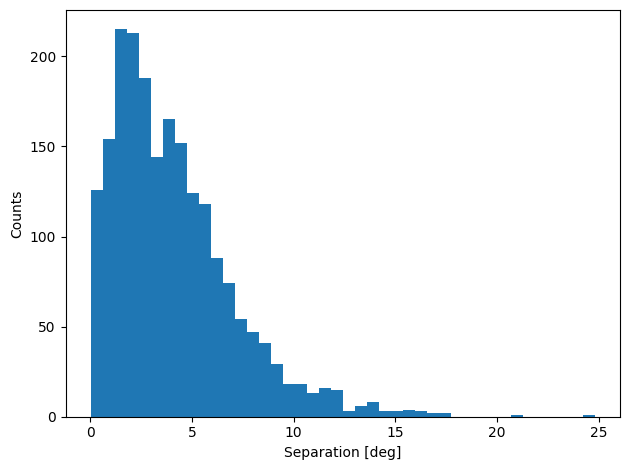

In [26]:
m = sep2d.value < 0.5
plt.figure()
plt.hist(sep2d, bins="auto")
plt.xlabel("Separation [deg]")
plt.ylabel("Counts")
plt.tight_layout()
plt.savefig("../../plots/sfi_gals_to_sfi_groups.png", bbox_inches="tight",
            dpi=450)
plt.show()

### 2MTF 

In [149]:
names = ["RA", "DEC", "mag", "e_mag", "z_CMB", "r_hMpc", "e_rhMpc", "M", "eta", "e_eta"]

dtype = [(n, np.float32) for n in names]
data = np.genfromtxt(join(tf_folder, "twomtf_k.csv"), delimiter=",", skip_header=1,
                     usecols=[2 + n for n in range(len(names))])

twomtf_gals = np.empty(len(data), dtype=dtype)
for i, n in enumerate(names):
    twomtf_gals[n] = data[:, i]

## Write to HDF5

In [151]:
outdir = "/mnt/extraspace/rstiskalek/catalogs"
fname = "PV_compilation.hdf5"

with File(join(outdir, fname), 'w') as f:
    # Write LOSS
    grp = f.create_group("LOSS")
    for name in loss_data.dtype.names:
        grp.create_dataset(name, data=loss_data[name])

    # Write Foundation
    grp = f.create_group("Foundation")
    for name in foundation_data.dtype.names:
        grp.create_dataset(name, data=foundation_data[name])

    # Write SFI gals
    grp = f.create_group("SFI_gals")
    for name in sfi_gals.dtype.names:
        grp.create_dataset(name, data=sfi_gals[name])

    # Write SFI gals masked
    grp = f.create_group("SFI_gals_masked")
    for name in sfi_gals_masked.dtype.names:
        grp.create_dataset(name, data=sfi_gals_masked[name])

    # Write SFI groups
    grp = f.create_group("SFI_groups")
    for name in sfi_groups.dtype.names:
        grp.create_dataset(name, data=sfi_groups[name])

    # Write 2MTF gals
    grp = f.create_group("2MTF")
    for name in twomtf_gals.dtype.names:
        grp.create_dataset(name, data=twomtf_gals[name])

    # Write Pantheon
    grp = f.create_group("Pantheon+")
    for name in pantheon_data.keys():
        grp.create_dataset(name, data=pantheon_data[name])